In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import Dataset
import random
%matplotlib inline

In [20]:
TRAIN_NUM_EXAMPLES = 20_000_000
TRAIN_NUM_WORDS = 200_000
VAL_NUM_WORDS = 3_000

LOAD_DATA_FROM_CACHE = False

In [21]:
# load the data in training_dictionary.txt
import os
current_dir = os.getcwd()
with open(
    f"{current_dir}/training_dictionary.txt", "r"
) as file:
    all_words = file.read().splitlines()
print(len(all_words))

224377


100%|██████████| 224377/224377 [00:00<00:00, 2471448.51it/s]


count    224377.000000
mean          9.591540
std           2.916634
min           1.000000
25%           8.000000
50%           9.000000
75%          11.000000
max          24.000000
Name: word_length, dtype: float64


array([[<Axes: title={'center': 'word_length'}>]], dtype=object)

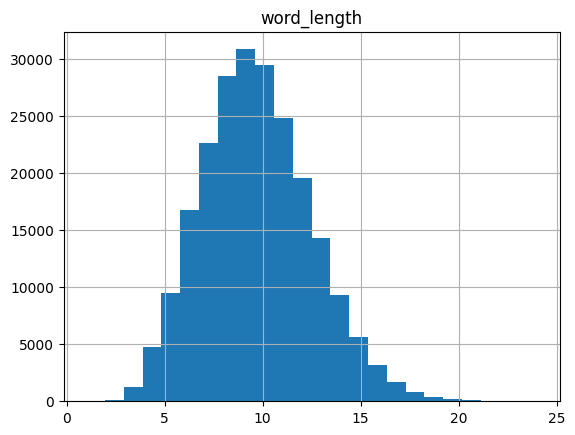

In [22]:
import pandas as pd

df = pd.DataFrame(
    {
        "word_length": [len(word) for word in tqdm(all_words)],
    }
)

print(df["word_length"].describe())

df.hist(column="word_length", bins=df["word_length"].max())

In [23]:
max_length = 25

words = [word for word in all_words if len(word) <= max_length]

In [24]:
import random

print(len(words))
random.seed(42)
random.shuffle(words)
words[:10]

224377


['reperplex',
 'dice',
 'hemibenthic',
 'plumatellid',
 'delatinize',
 'mermithization',
 'rixatrix',
 'preassurance',
 'desensitize',
 'mele']

In [25]:
len("".join(words))

2152121

In [26]:
longest_word = max(words, key=len)
print(longest_word, len(longest_word))

tetraiodophenolphthalein 24


In [27]:
vocab = set("".join(words))
vocab = [".", "_"] + sorted(list(vocab))
vocab_size = len(vocab)
print(vocab_size)
stoi = {char: i for i, char in enumerate(vocab)}
itos = {i: char for char, i in stoi.items()}
print(stoi)
print(itos)

29
{'.': 0, '_': 1, '-': 2, 'a': 3, 'b': 4, 'c': 5, 'd': 6, 'e': 7, 'f': 8, 'g': 9, 'h': 10, 'i': 11, 'j': 12, 'k': 13, 'l': 14, 'm': 15, 'n': 16, 'o': 17, 'p': 18, 'q': 19, 'r': 20, 's': 21, 't': 22, 'u': 23, 'v': 24, 'w': 25, 'x': 26, 'y': 27, 'z': 28}
{0: '.', 1: '_', 2: '-', 3: 'a', 4: 'b', 5: 'c', 6: 'd', 7: 'e', 8: 'f', 9: 'g', 10: 'h', 11: 'i', 12: 'j', 13: 'k', 14: 'l', 15: 'm', 16: 'n', 17: 'o', 18: 'p', 19: 'q', 20: 'r', 21: 's', 22: 't', 23: 'u', 24: 'v', 25: 'w', 26: 'x', 27: 'y', 28: 'z'}


In [28]:
# create a dataset where each character is masked with an underscore
block_size = max_length

In [29]:
dataset = []
# Truncate word to block_size or fill them with '.' if it's too short. Use '_' for the single masked character. There must only be one '_' per word.
truncated_words = []
for word in words:
    # Pad shorter words with '.' to match block_size
    if len(word) < block_size:
        word = word + "." * (block_size - len(word))

    # Use sliding window to generate subwords
    for i in range(len(word) - block_size + 1):
        subword = word[i : i + block_size]
        truncated_words.append(subword)

print(len(truncated_words))
truncated_words[:30]

224377


['reperplex................',
 'dice.....................',
 'hemibenthic..............',
 'plumatellid..............',
 'delatinize...............',
 'mermithization...........',
 'rixatrix.................',
 'preassurance.............',
 'desensitize..............',
 'mele.....................',
 'codfisher................',
 'metrorrhagia.............',
 'dispiece.................',
 'malagigi.................',
 'undetractingly...........',
 'vanillal.................',
 'dowery...................',
 'blepharal................',
 'osnappar.................',
 'phoronic.................',
 'behold...................',
 'brigand..................',
 'lots.....................',
 'thingamabob..............',
 'aureation................',
 'phosphene................',
 'kolach...................',
 'raja.....................',
 'rhipiphorid..............',
 'unagitatedly.............']

In [30]:
def masked_words(word: str):
    if not word:
        return []

    result = []

    # Get unique characters in the word
    unique_chars = list(set(word) - {"."})

    # Generate all possible combinations of which characters to mask
    # For n unique characters, we have 2^n possibilities
    for i in range(1, 2 ** len(unique_chars)):  # Start from 1 to exclude no masks
        chars_to_mask = set()

        # Determine which characters to mask based on bit pattern
        for j in range(len(unique_chars)):
            if i & (1 << j):
                chars_to_mask.add(unique_chars[j])

        # Create the masked string
        masked = ""
        for char in word:
            if char in chars_to_mask:
                masked += "_"
            else:
                masked += char

        # Create a tuple for each masked character type
        # for char in chars_to_mask:
        result.append((masked, word))

    return result


print(masked_words("app"))
print(masked_words("app."))
print(masked_words("xyz"))
print(masked_words("xyz.."))

[('_pp', 'app'), ('a__', 'app'), ('___', 'app')]
[('_pp.', 'app.'), ('a__.', 'app.'), ('___.', 'app.')]
[('x_z', 'xyz'), ('_yz', 'xyz'), ('__z', 'xyz'), ('xy_', 'xyz'), ('x__', 'xyz'), ('_y_', 'xyz'), ('___', 'xyz')]
[('x_z..', 'xyz..'), ('_yz..', 'xyz..'), ('__z..', 'xyz..'), ('xy_..', 'xyz..'), ('x__..', 'xyz..'), ('_y_..', 'xyz..'), ('___..', 'xyz..')]


In [31]:
%%time

def gen_dataset(truncated_words: list[str]):
    dataset = []
    for word in truncated_words:
        dataset.extend(masked_words(word))
    return dataset


# dataset = list(set(dataset))

if not LOAD_DATA_FROM_CACHE:
    # print the first 10 elements of the dataset
    train_dataset = gen_dataset(truncated_words[:TRAIN_NUM_WORDS])
    print(len(train_dataset))
    print(train_dataset[:10])

    val_dataset = gen_dataset(truncated_words[-VAL_NUM_WORDS:])
    print(len(val_dataset))
    print(val_dataset[:10])

94041916
[('reperple_................', 'reperplex................'), ('_epe_plex................', 'reperplex................'), ('_epe_ple_................', 'reperplex................'), ('r_p_rpl_x................', 'reperplex................'), ('r_p_rpl__................', 'reperplex................'), ('__p__pl_x................', 'reperplex................'), ('__p__pl__................', 'reperplex................'), ('reperp_ex................', 'reperplex................'), ('reperp_e_................', 'reperplex................'), ('_epe_p_ex................', 'reperplex................')]
1406556
[('pytha_orism..............', 'pythagorism..............'), ('pythag_rism..............', 'pythagorism..............'), ('pytha__rism..............', 'pythagorism..............'), ('pythagori_m..............', 'pythagorism..............'), ('pytha_ori_m..............', 'pythagorism..............'), ('pythag_ri_m..............', 'pythagorism..............'), ('pytha__ri_m........

In [32]:
%%time

random.seed(42)
if not LOAD_DATA_FROM_CACHE:
  random.shuffle(train_dataset)
  train_dataset = train_dataset[:TRAIN_NUM_EXAMPLES]

CPU times: user 57.9 s, sys: 104 ms, total: 58 s
Wall time: 58 s


In [33]:
%%time
# convert the words to a list of ints
def integerize_dataset(dataset: list[tuple[str, str]]):
    integerized_dataset = []
    for word, label in dataset:
        integerized_dataset.append(
            ([stoi[char] for char in word], [stoi[char] for char in label])
        )
    return integerized_dataset

if not LOAD_DATA_FROM_CACHE:
    train_integerized_dataset = integerize_dataset(train_dataset)
    print(train_integerized_dataset[0])

    val_integerized_dataset = integerize_dataset(val_dataset)
    print(val_integerized_dataset[0])

([4, 7, 1, 1, 7, 7, 1, 1, 10, 1, 14, 7, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [4, 7, 22, 25, 7, 7, 16, 25, 10, 11, 14, 7, 21, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
([18, 27, 22, 10, 3, 1, 17, 20, 11, 21, 15, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [18, 27, 22, 10, 3, 9, 17, 20, 11, 21, 15, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
CPU times: user 2min 26s, sys: 3.82 s, total: 2min 29s
Wall time: 2min 29s


In [34]:
%%time

if not LOAD_DATA_FROM_CACHE:
  random.shuffle(train_integerized_dataset)
  random.shuffle(val_integerized_dataset)

CPU times: user 9.51 s, sys: 741 μs, total: 9.51 s
Wall time: 9.51 s


In [35]:
%%time
import pickle
train_dataset_path = f"{current_dir}/train_dataset.pkl"
val_dataset_path = f"{current_dir}/val_dataset.pkl"


CPU times: user 4 μs, sys: 0 ns, total: 4 μs
Wall time: 5.96 μs


In [36]:
if not LOAD_DATA_FROM_CACHE:
  print(f"Saving train dataset to {train_dataset_path}")
  with open(train_dataset_path, "wb") as f:
      pickle.dump(train_integerized_dataset, f)

  print(f"Saving val dataset to {val_dataset_path}")
  with open(val_dataset_path, "wb") as f:
      pickle.dump(val_integerized_dataset, f)



# # torch.save(train_integerized_dataset, train_dataset_path)
# # torch.save(val_integerized_dataset, val_dataset_path)

# # # load datasets from disk
# # train_dataset = torch.load(train_dataset_path)
# # val_dataset = torch.load(val_dataset_path)

Saving train dataset to /home/ubuntu/transformer-hangman-solver/train_dataset.pkl
Saving val dataset to /home/ubuntu/transformer-hangman-solver/val_dataset.pkl


In [37]:
%%time
if LOAD_DATA_FROM_CACHE:
    print(f"Loading train dataset from {train_dataset_path}")
    with open(train_dataset_path, "rb") as f:
        train_integerized_dataset = pickle.load(f)

    print(f"Loading val dataset from {val_dataset_path}")
    with open(val_dataset_path, "rb") as f:
        val_integerized_dataset = pickle.load(f)


CPU times: user 3 μs, sys: 0 ns, total: 3 μs
Wall time: 5.48 μs


In [38]:
%%time
# create a pytorch dataset of word and label pairs

class HangmanDataset(Dataset):
    def __init__(self, words):
        self.features = torch.tensor([x[0] for x in words])
        self.labels = torch.tensor([x[1] for x in words])

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]


train_dataset = HangmanDataset(train_integerized_dataset)
val_dataset = HangmanDataset(val_integerized_dataset)

print(len(train_dataset))
# print(train_dataset[[0, 1, 2]])

print(len(val_dataset))

20000000
1406556
CPU times: user 2min 9s, sys: 2.98 s, total: 2min 12s
Wall time: 2min 11s


In [39]:
from dataclasses import dataclass
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import math
from tqdm import tqdm
import time

@dataclass
class GPTConfig:
    block_size: int = 1024  # Max sequence length
    vocab_size: int = (
        50257  # number of tokens: 50,000 BPE merges + 256 bytes tokens + 1 <|endoftext|> token
    )
    n_layer: int = 12  # number of layers
    n_head: int = 12  # number of attention heads
    n_embd: int = 768  # embedding dimension


class CausalSelfAttention(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        assert config.n_embd % config.n_head == 0

        # key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd)
        # output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd)
        self.c_proj.NANOGPT_SCALE_INIT = 1

        # regularization
        self.n_head = config.n_head
        self.n_embd = config.n_embd

        # not really a 'bias', more of a mask, but following the OpenAI/HF naming though
        self.register_buffer(
            "bias",
            torch.tril(torch.ones(config.block_size, config.block_size)).view(
                1, 1, config.block_size, config.block_size
            ),
        )

    def forward(self, x):
        B, T, C = x.size()

        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        # nh is "number of heads", hs is "head size", and C (number of channels) is the embedding dimension
        qkv = self.c_attn(x)
        q, k, v = qkv.split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(
            1, 2
        )  # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(
            1, 2
        )  # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(
            1, 2
        )  # (B, nh, T, hs)

        # causal self-attention; Self-attend: (B, nh, T, hs) x (B, nh, hs, T) -> (B, nh, T, T)
        # att = (q @ k.transpose(-2, -1)) * (1 / math.sqrt(k.size(-1)))
        # att = att.masked_fill(self.bias[:, :, :T, :T] == 0, float("-inf"))
        # att = F.softmax(att, dim=-1)
        # y = att @ v  # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)

        y = F.scaled_dot_product_attention(q, k, v, is_causal=False)

        y = (
            y.transpose(1, 2).contiguous().view(B, T, C)
        )  # re-assemble all head outputs side by side

        # output projection
        y = self.c_proj(y)
        return y


class MLP(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.c_fc = nn.Linear(config.n_embd, 4 * config.n_embd)
        self.gelu = nn.GELU(approximate="tanh")
        self.c_proj = nn.Linear(4 * config.n_embd, config.n_embd)
        self.c_proj.NANOGPT_SCALE_INIT = 1

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        return x


class Block(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.ln_1 = nn.LayerNorm(config.n_embd)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = nn.LayerNorm(config.n_embd)
        self.mlp = MLP(config)

    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x


class GPT(nn.Module):

    def __init__(self, config: GPTConfig):
        super().__init__()
        self.config = config

        self.transformer = nn.ModuleDict(
            dict(
                wte=nn.Embedding(config.vocab_size, config.n_embd),
                wpe=nn.Embedding(config.block_size, config.n_embd),
                h=nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
                ln_f=nn.LayerNorm(config.n_embd),
            )
        )
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

        # weight sharing scheme
        self.transformer.wte.weight = self.lm_head.weight

        # init params
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            std = 0.02  # roughly equivalent to 1/sqrt(d_model)
            if hasattr(module, "NANOGPT_SCALE_INIT"):
                std *= (2 * self.config.n_layer) ** -0.05
            torch.nn.init.normal_(
                module.weight,
                mean=0.0,
                std=std,
            )
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(
                module.weight,
                mean=0.0,
                std=0.02,  # roughly equivalent to 1/sqrt(d_model)
            )

    def forward(self, idx, targets=None):
        # idx and targets are both (B, T) tensor of integers token indices
        B, T = idx.size()
        assert (
            T <= self.config.block_size
        ), f"Cannot forward sequence of length {T}, block size is only {self.config.block_size}"

        pos = torch.arange(0, T, dtype=torch.long, device=idx.device)
        pos_emb = self.transformer.wpe(pos)  # position embeddings of shape (T, n_embed)
        tok_emb = self.transformer.wte(idx)  # token embeddings of shape (B, T, n_embed)
        x = tok_emb + pos_emb
        # forward the blocks of the transformer
        for block in self.transformer.h:
            x = block(x)
        # forward the final layer norm and the classifier
        x = self.transformer.ln_f(x)  # (B, T, n_embed)
        logits = self.lm_head(x)  # (B, T, vocab_size)

        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))
        return logits, loss


In [40]:
# Create a transformer model for the hangman game


d_model = 512
nhead = 8
num_layers = 4

device = (
    "cuda"
    if torch.cuda.is_available()
    else ("mps" if torch.backends.mps.is_available() else "cpu")
)

print("Using device:", device)

torch.set_float32_matmul_precision("high")

opt_vocab_size = vocab_size
opt_block_size = block_size

# create a transformer model
model = GPT(GPTConfig(
    block_size=opt_block_size,
    vocab_size=opt_vocab_size,
    n_layer=num_layers,
    n_head=nhead,
    n_embd=d_model,
))
print("Number of parameters:", f"{sum(p.numel() for p in model.parameters()):,}")

model.to(device)
model = torch.compile(model)
# create a loss function
criterion = nn.CrossEntropyLoss()

# create an optimizer
optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=0.0, betas=(0.9, 0.95))

# train the model
batch_size = 4096
num_epochs = 1

cosine_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=(len(train_dataset) // batch_size) * num_epochs)

lossi = []
val_lossi = []
val_step = []
step = 0

val_features, val_labels = val_dataset[:10000]
val_features = val_features.to(device)
val_labels = val_labels.to(device)
for epoch in range(num_epochs):
    for i in (pbar := tqdm(range(0, len(train_dataset), batch_size))):
        t0 = time.time()
        # idx = torch.randint(0, len(train_dataset), (batch_size,))
        features, labels = train_dataset[i : i + batch_size]
        features = features.to(device)
        labels = labels.to(device)
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        with torch.autocast(device_type=device, dtype=torch.bfloat16):
            logits, loss = model(features, labels)


        # Backward pass
        loss.backward()

        norm = torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update weights
        optimizer.step()
        cosine_scheduler.step()
        torch.cuda.synchronize()

        t1 = time.time()
        dt = (t1 - t0) * 1000  # ms
        lossi.append(loss.item())

        if step % 20 == 0:
            model.eval()
            with torch.no_grad():
                _, val_loss = model(val_features, val_labels)
                val_lossi.append(val_loss.item())
                val_step.append(step)
            model.train()

        tokens_per_second = (batch_size * block_size) / (t1 - t0)
        pbar.set_description(
            f"Epoch {epoch+1}/{num_epochs} | Train Loss: {loss.item():.4f} | Val Loss: {val_loss.item():.4f} | Norm: {norm:.4f} | {dt:.2f}ms/batch | {tokens_per_second:.2f} tok/s"
        )
        step += 1

Using device: cuda
Number of parameters: 12,638,208


Epoch 1/1 | Train Loss: 0.2120 | Val Loss: 0.3056 | Norm: 0.2391 | 13941.46ms/batch | 7345.00 tok/s: 100%|██████████| 4883/4883 [05:52<00:00, 13.83it/s]  


In [41]:
model_path = f"{current_dir}/model.pth"
torch.save(model.state_dict(), model_path)

In [42]:
# bkp_model = model

In [43]:
# model = GPT(GPTConfig(
#     block_size=opt_block_size,
#     vocab_size=opt_vocab_size,
#     n_layer=num_layers,
#     n_head=nhead,
#     n_embd=d_model,
# ))
# model.load_state_dict(torch.load(model_path))
# model.to(device)
# model.eval()


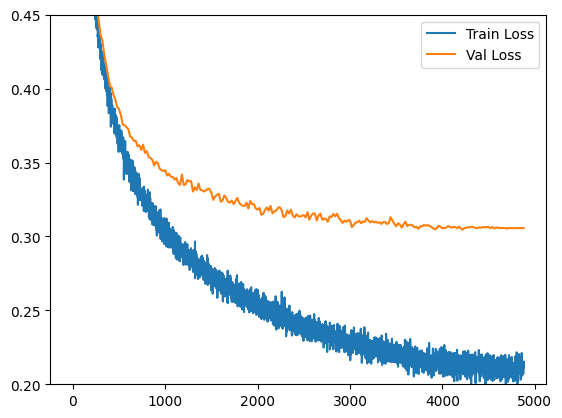

In [44]:
plt.plot(lossi)
plt.plot(val_step, val_lossi)
plt.legend(["Train Loss", "Val Loss"])
# start x axis at 1000
plt.ylim(0.2, 0.45)
plt.show()

In [45]:
def full_eval(dataset, batch_size=1024 * 4):
    model.eval()
    with torch.no_grad():
        losses = []
        for i in (pbar := tqdm(range(0, 100000, batch_size))):
            features, labels = dataset[i : i + batch_size]
            features = features.to(device)
            labels = labels.to(device)
            logits, loss = model(features, labels)
            losses.append(loss.item())
        print(np.mean(losses))

full_eval(train_dataset)
full_eval(val_dataset)

print("\n")

100%|██████████| 25/25 [00:00<00:00, 37.73it/s]


0.2106047648191452


100%|██████████| 25/25 [00:00<00:00, 36.62it/s]

0.3031506884098053




In [ ]:
# inference:


def predict(model, word, max_guesses=6, verbose=False):
    if verbose:
        print("word", word)
    guesses = []
    model.eval()
    # model.to(device)
    i = 0
    with torch.no_grad():
        while True:
            i += 1
            # print(guesses)
            masked_word = "".join(
                ["_" if char != "." and char not in guesses else char for char in word]
            )
            if verbose:
                print("masked_word", masked_word, guesses)
            if masked_word == word:
                break
            if len([g for g in guesses if g not in word]) >= max_guesses:
                break

            integerized_word = [stoi[c] for c in masked_word]
            features = torch.tensor([integerized_word])
            features = features.to(device)
            logits, _ = model(features)
            probs = torch.softmax(logits[0], dim=-1)

            mask_indices = [i for i, c in enumerate(masked_word) if c == "_"]
            ensemble_probs = torch.mean(probs[mask_indices], dim=0)
            topk_probs, topk_indices = torch.topk(ensemble_probs, k=vocab_size, dim=-1)
            letter_guesses = [
                (itos[int(idx.item())], f"{p.item() * 100:.2f}%")
                for idx, p in zip(topk_indices, topk_probs)
            ]
            letter_guesses = [
                (letter_guess, prob)
                for letter_guess, prob in letter_guesses
                if letter_guess not in guesses and letter_guess not in [".", "_"]
            ]
            # letter_guesses.sort(key=lambda x: x[1], reverse=True)
            if verbose:
                print("Guess:", ', '.join([f"'{letter_guess}': {prob}" for letter_guess, prob in letter_guesses]))
            for letter_guess, _ in letter_guesses:
                guesses.append(letter_guess)
                if (
                    letter_guess in word
                    or len([g for g in guesses if g not in word]) == max_guesses
                ):
                    break
    return masked_word, guesses


predict(model, truncated_words[0], max_guesses=6, verbose=True)
print(len(truncated_words))


def compute_winrate(words: list[str]):
    wins = 0
    total = 0
    for word in (pbar := tqdm(words)):
        masked_word, guesses = predict(model, word, max_guesses=6, verbose=False)
        if masked_word == word:
            wins += 1
        total += 1
        pbar.set_description(f"Win rate: {wins / total * 100:.2f}%")


print(TRAIN_NUM_EXAMPLES)
print("In sample")
compute_winrate(truncated_words[:3000])
print("Out of sample")
compute_winrate(truncated_words[-VAL_NUM_WORDS:])

word reperplex................
masked_word _________................ []
Guess: 'e': 11.10%, 'i': 9.03%, 'a': 8.76%, 'o': 7.20%, 'r': 7.07%, 'n': 6.72%, 't': 6.54%, 's': 6.07%, 'l': 5.75%, 'c': 4.19%, 'u': 3.94%, 'd': 3.42%, 'm': 3.24%, 'p': 3.04%, 'h': 2.74%, 'y': 2.11%, 'g': 2.09%, 'b': 1.89%, 'f': 1.20%, 'k': 1.04%, 'w': 0.90%, 'v': 0.87%, 'z': 0.44%, 'x': 0.29%, 'q': 0.19%, 'j': 0.16%, '-': 0.00%
masked_word _e_e___e_................ ['e']
Guess: 'r': 17.86%, 't': 9.66%, 'd': 9.12%, 'a': 7.35%, 'l': 6.59%, 'i': 5.85%, 's': 5.24%, 'n': 4.92%, 'm': 4.28%, 'b': 3.88%, 'c': 3.61%, 'v': 3.11%, 'h': 2.97%, 'p': 2.51%, 'o': 2.47%, 'g': 2.45%, 'f': 2.04%, 'w': 1.47%, 'z': 1.37%, 'u': 1.04%, 'k': 1.01%, 'j': 0.41%, 'y': 0.41%, 'x': 0.29%, 'q': 0.07%, '-': 0.00%
masked_word re_er__e_................ ['e', 'r']
Guess: 'd': 15.95%, 'v': 14.53%, 'a': 11.65%, 't': 10.90%, 'l': 6.83%, 'i': 6.78%, 's': 6.46%, 'p': 3.67%, 'n': 2.96%, 'c': 2.82%, 'g': 2.67%, 'f': 2.55%, 'o': 2.50%, 'u': 1.71%, 'h': 1

Win rate: 68.10%: 100%|██████████| 3000/3000 [00:46<00:00, 64.10it/s]


Out of sample


Win rate: 66.57%: 100%|██████████| 3000/3000 [00:35<00:00, 83.93it/s] 
